# CITS4403 - Perth Train Network from Slime Mould

22234771 - Benjamin Longbottom

## Imports

In [1]:
import numpy as np
import matplotlib.animation as ani
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

### Enable matplotlib interactive plots

In [2]:
%matplotlib notebook

## Grid Class

In [128]:
class Grid:
    """
    A grid in 2 dimensional space, with a single value assigned to each cell.
    
    - Cartesian plane
    - (x, y) indexing 
    - lower left origin
    """
    
    def __init__(self, shape=(200, 100), dtype=np.float32):
        self.shape = shape
        self.width, self.height = shape
        self.grid = self.setup_grid()
        self._im = None
        self.dtype = dtype
    
    def setup_grid(self):
        return self.clear_grid()
    
    def clear_grid(self):
        self.grid = np.zeros((self.shape), dtype=self.dtype)
        return self.grid
    
    def randomise_grid(self):
        self.grid = np.random.rand(self.height, self.width)
        return self.grid
    
    def add_spot(self, centre_point, value, radius=1):
        x_centre, y_centre = centre_point
        for xi in range(x_centre-radius, x_centre+radius+1):
            for yi in range(y_centre-radius, y_centre+radius+1):
                self.grid[xi, yi] = value
    
    def draw(self, animated=False):
        """ Draws the current CA state on a 2D cartesian plane. """
        transposed_grid = self.grid.T
        if self._im is None:
            self._im = plt.imshow(transposed_grid, origin='lower', animated=animated)
        else:
            self._im.set_array(transposed_grid)
        return self._im
        

## Grid Types

In [129]:
class Diffusion_Grid(Grid):
    """ Diffuses values to neighbouring cells. """
    
    diffusion_kernel = np.array([[.05, .2, .05],
                                [ .2, -1, .2],
                                [.05, .2, .05]])
    
    def diffuse(self, diffusion_rate=0.5):
        diffusion_mask = correlate2d(self.grid, self.diffusion_kernel, mode='same')
        self.grid = self.grid + diffusion_rate * diffusion_mask
        return self.grid

In [134]:
class Distance_Grid(Grid):
    """ Expands outwards and stores distance from starting point. """
    
    def __init__(shape=(200, 100)):
        super(shape=(200, 100), dtype=np.int32)
        
    def setup_grid(self):
#         self.grid # = 
        return self.grid
    
    def step(self):
        self.grid
        # What indicates 'starting' position (ie. food positions?)
        # how to differentiate between distances to different food sources
        
        

## Slime Mould - Cellular Automata Model

In [130]:
class Slime_CA:
    
    def __init__(self, grid_shape=[20, 10]):
        self.diffusion_grid = Diffusion_Grid(grid_shape)
    
    def add_food(self, centre_point, value, radius=1):
        self.diffusion_grid.add_spot(centre_point, value, radius)
    
    def step(self):
        return self.diffusion_grid.diffuse(diffusion_rate=0.5)
         
    def draw(self, animated=False):
        return self.diffusion_grid.draw(animated=animated)

## Cellular Automata Animator

In [131]:
class CA_Animator:
    
    def __init__(self, ca, fig=None):
        self.ca = ca
        if fig is None:
            fig = plt.figure()
        self.fig = fig
        self.current_frame = 0
     
    def animate(self, frame_count=10, interval=20):
        self.frame_count = frame_count
        
        self.anim = ani.FuncAnimation(
            self.fig, 
            self._update_frame, 
            init_func=self._setup_fig, 
            frames=self.frame_count, 
            interval=interval,
            repeat=False)
        
        plt.show()
        return self.anim
    
    def _setup_fig(self, *args):
        self.im = self.ca.draw(animated=True)
        return (self.im,)
    
    def _update_frame(self, frame_index):
        new_grid = self.ca.step()
        self.im = self.ca.draw()
        if frame_index <= self.frame_count:
            self.current_frame = frame_index
            return (self.im,)


## Running the Slime Mould CA model

<IPython.core.display.Javascript object>


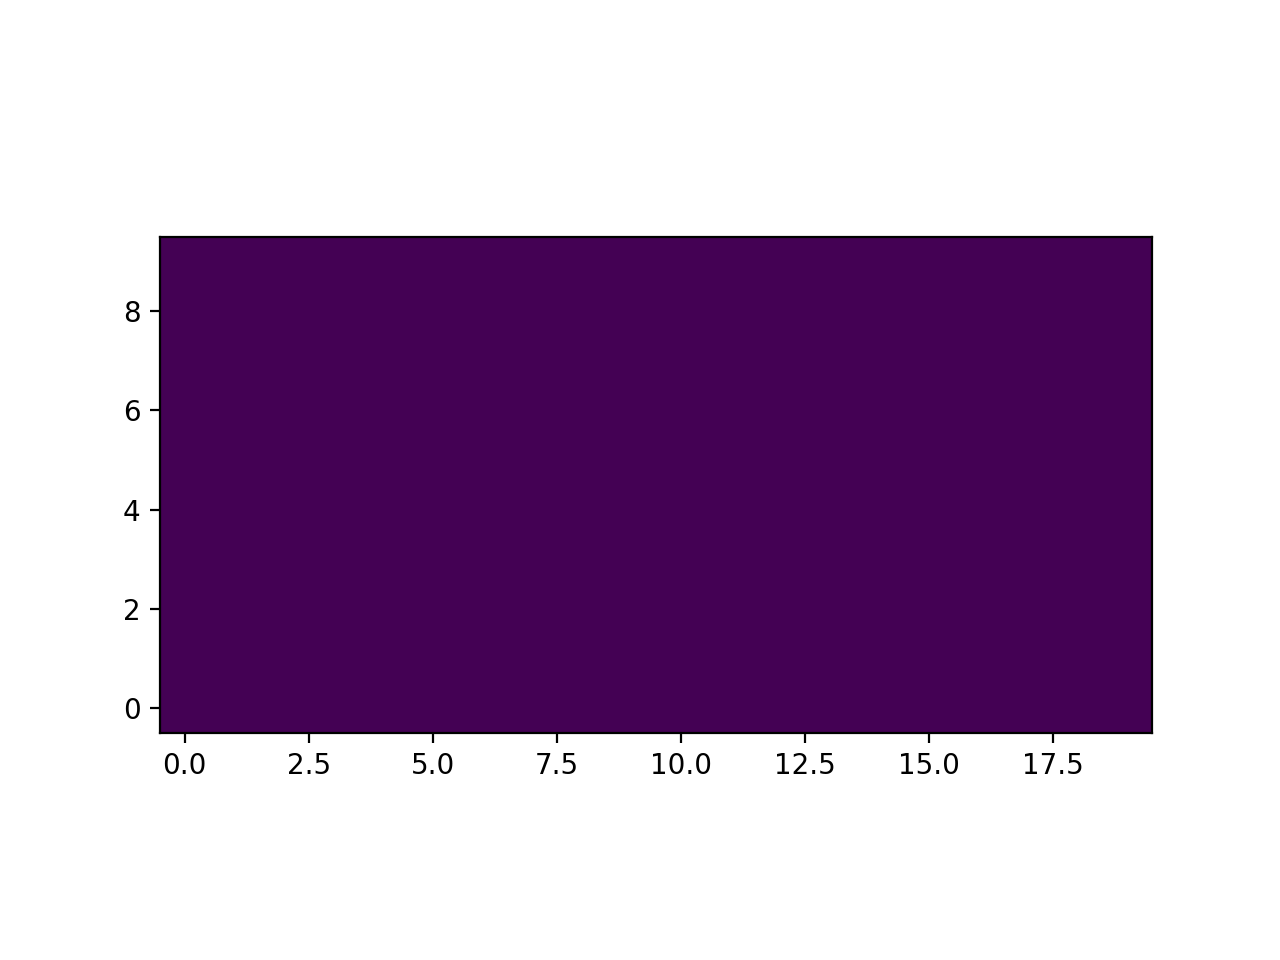

In [132]:
ca = Slime_CA(grid_shape=(20,10))
ca.add_food((10, 5), 100, radius=1)
ca.add_food((10, 2), 100, radius=1)
animator = CA_Animator(ca)
animator.animate(frame_count=500, interval=10)